# k-nearest-Neighbour

## Load datasets

Total Image count:  500
Train Dataset Size: 375
Test Dataset Size: 125


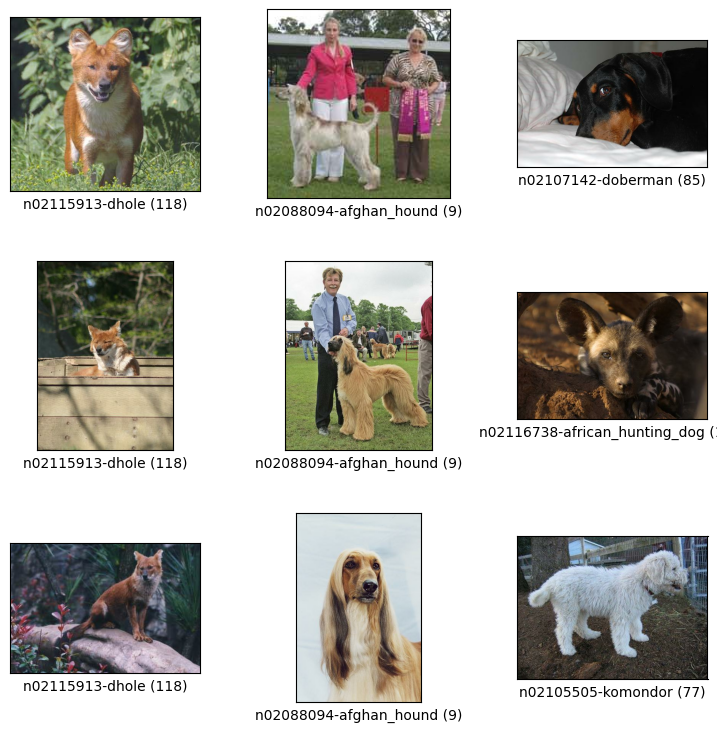

/Users/jannisgehring/VSCode/ml-lecture/utils/setup.py:44: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


,image,image/filename,label,objects/bbox
0,,Images/n02115913-dhole/n02115913_3998.jpg,118 (n02115913-dhole),
1,,Images/n02088094-Afghan_hound/n02088094_4049.jpg,9 (n02088094-afghan_hound),
2,,Images/n02107142-Doberman/n02107142_971.jpg,85 (n02107142-doberman),
3,,Images/n02115913-dhole/n02115913_2895.jpg,118 (n02115913-dhole),

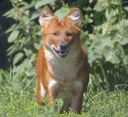
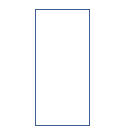
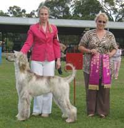
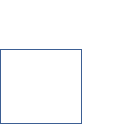
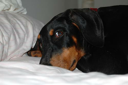
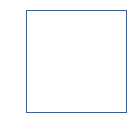
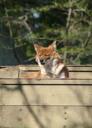
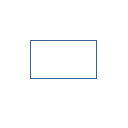

In [31]:
import tensorflow_datasets as tfds
import tensorflow as tf
from pathlib import Path
import sys
import numpy as np
import random

random_seed = 42
np.random.seed(random_seed)
random.seed(random_seed)
notebook_dir = Path().resolve()
sys.path.append(str(notebook_dir.parent))

from utils.setup import setup_dataset


train_dataset, test_dataset, table, info = setup_dataset('../dataset', show_examples=True)

## Merkmale
Die folgenden Merkmale wurden zur Merkmalsextraktion definiert:
https://gvpress.com/journals/IJMUE/vol8_no4/39.pdf

Farb-merkmale:
1. Helligkeit des Fells
2. Farbvarianz des Fells

Textur-merkmale:

3. Fellstruktur

Form-merkmale:

4. Form des Hunds auf dem Bild




Ideen:
- Histogramm
    - Maximaler Wert
    - Median
    - Mittelwert
    - Kurtosis
- Rechtecke
    - Anzahl der gefundenen Regionen
    - Avg(Höhe)/Avg(Breite)
    - Avg(Höhe)
    - Avg(Breite)

- 



# Creating feature vector

In [32]:
from skimage.feature import local_binary_pattern, hog
from skimage import exposure
import scipy.stats as ss
from skimage.measure import regionprops_table
import matplotlib.patches as mpatches
from skimage.morphology import label as skimage_label
from skimage.feature import canny
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def colorTensor2grayNparray(image):
    return tf.image.rgb_to_grayscale(image).cpu().numpy()[:,:,0]

def computeHistogrammFeatures(img):
    output = []

    for layer in [0,1,2]:
        values, _ = np.histogram(img[:,:,layer], bins=np.arange(256))
        nobs, (minimum, maximum), mean, variance, skewness, kurtosis = ss.describe(values)
        output += (
            mean,
            skewness, kurtosis,
            minimum,
            maximum,
            variance
        )
    return output

def computeRegionFeatures(img):
    img_grayscale_np = colorTensor2grayNparray(img)

    edges = canny(img_grayscale_np,
        1.5)
    label_image = skimage_label(edges)

    properties=("bbox","area_bbox", "axis_major_length", "axis_minor_length", "orientation", "solidity")
    regions = regionprops_table(label_image,properties=properties)
    df = pd.DataFrame(regions)

    # Filter outliers
    df = df[ (df["area_bbox"] > 10) & (df["area_bbox"] < df["area_bbox"].quantile(0.9))]
    df = df[ (df["axis_major_length"] > 1) & (df["axis_major_length"] < df["axis_major_length"].quantile(0.95))]
    df = df[ (df["axis_minor_length"] > 1) & (df["axis_minor_length"] < df["axis_minor_length"].quantile(0.95))]

    num_regions = df.shape[0]
    df["bbox_height_width_ratio"] = (df["bbox-3"]-df["bbox-1"])/(df["bbox-2"]-df["bbox-0"])
    df["axis_ratio"] = (df["axis_major_length"])/(df["axis_minor_length"])
    df = df.drop(columns=["bbox-0","bbox-1", "bbox-2", "bbox-3"])
    df = df.describe()

    return (
        num_regions,

        df.at["mean", "bbox_height_width_ratio"],
        df.at["std", "bbox_height_width_ratio"],
        df.at["25%", "bbox_height_width_ratio"],
        df.at["75%", "bbox_height_width_ratio"],

        df.at["mean", "axis_ratio"],
        df.at["std", "axis_ratio"],
        df.at["25%", "axis_ratio"],
        df.at["75%", "axis_ratio"],

        df.at["mean", "area_bbox"],
        df.at["std", "area_bbox"],
        df.at["25%", "area_bbox"],
        df.at["75%", "area_bbox"],

        df.at["mean", "axis_major_length"],
        df.at["std", "axis_major_length"],
        df.at["25%", "axis_major_length"],
        df.at["75%", "axis_major_length"],

        df.at["mean", "axis_minor_length"],
        df.at["std", "axis_minor_length"],
        df.at["25%", "axis_minor_length"],
        df.at["75%", "axis_minor_length"],

        df.at["mean", "orientation"],
        df.at["std", "orientation"],
    )

def computeLBPfeatures(img):
    img_grayscale_np = colorTensor2grayNparray(img)
    radius = 3
    n_points = radius*8
    lbp = local_binary_pattern(img_grayscale_np, n_points, radius)
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(3,n_points+3), range=(5, n_points+2))
    hist = hist.astype("float")
    hist/=hist.sum()
    #plt.bar(range(len(hist)), hist)
    #plt.show()
    sorted_with_index = sorted(enumerate(hist), key=lambda x: -x[1])
    max_values_indices = [index for index, value in sorted_with_index]
    return (
        *max_values_indices[:4],
    )

def computeHogFeatures(img):
    img = colorTensor2grayNparray(img)
    fd, hog_image = hog(
        img,
        orientations=8,
        pixels_per_cell=(32,16),
        cells_per_block=(10,10),
        visualize=True,
    )
    print(hog_image.shape)
    print(list(fd))
    plt.bar(range(fd.shape[0]), fd)
    plt.show()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

    ax1.axis("off")
    ax1.imshow(img, cmap=plt.cm.gray)
    ax1.set_title("Input image")

    # Rescale histogram for better display
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

    ax2.axis("off")
    ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
    ax2.set_title("Histogram of Oriented Gradients")
    plt.show()

def computeHoughFeatures(img):
    img_grayscale_np = colorTensor2grayNparray(img)

    edges = canny(img_grayscale_np, 1.5)


images = [sample["image"] for sample in train_dataset.take(10)]
labels = [sample["label"] for sample in train_dataset.take(10)]

i = 8
computeHistogrammFeatures(images[i])

2024-12-18 00:15:08.311587: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


[470.5882352941176,
 0.7187429713684703,
 -0.146080578434316,
 0,
 1363,
 136145.3061602594,
 470.5882352941176,
 0.7614266762508187,
 -0.13635307488552373,
 0,
 1284,
 118169.19592403893,
 470.5882352941176,
 1.053941410654912,
 0.20614105738549826,
 23,
 1235,
 90274.39277443264]

In [33]:
import numpy as np
from tqdm import tqdm

# Feature Extraction

def imageToVector(img) -> np.ndarray:
    extractionMethods = (
        computeHistogrammFeatures,
        computeRegionFeatures,
        computeLBPfeatures,
    )
    vector = []
    for method in extractionMethods:
        features = method(img)
        vector+=features
    return np.array(vector)

def datasetToVectorLabels(dataset):
    vectors, labels = [], []
    for sample in tqdm(dataset, desc="Iterating images:"):
        vectors.append(imageToVector(sample["image"].numpy()))
        labels.append(sample["label"].numpy())
    vectors = np.array(vectors)
    return vectors, labels

x_train_initial, y_train = datasetToVectorLabels(train_dataset)
x_test_initial, y_test = datasetToVectorLabels(test_dataset)

Iterating images:: 375it [01:06,  5.68it/s]
Iterating images:: 125it [00:28,  4.32it/s]


In [87]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler
from sklearn.decomposition import PCA, KernelPCA, IncrementalPCA, FastICA
from sklearn.manifold import TSNE
from sklearn.feature_selection import SequentialFeatureSelector, SelectKBest, SelectPercentile, RFE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import itertools
import bisect
from tqdm import tqdm
from functools import reduce


parameters = {
    "n_neigbors": [5,9,10,11,12,13,17],
    "scaler_type": [StandardScaler],
    "selector_name": ["percentile"],
    "percentile_value": list(range(30,80)),
    "n_features_to_select": [3,4,5,6,7,10,12,14,16],
    "reductor_type": [IncrementalPCA],
}
all_combs = itertools.product(*parameters.values())
n_configs = reduce(lambda x, y: x*y, [len(values) for values in parameters.values()], 1)
best_combs = []
tqdm_config = {
    "total": n_configs,
    "desc": "Testing configs:",
    "bar_format": '{l_bar}{bar:20}{r_bar}{bar:-10b}',
}
for configuration in tqdm(all_combs, **tqdm_config):

    knn = KNeighborsClassifier(n_neighbors=n_neighbors)

    #Unpack configuration values
    (
        n_neighbors,
        scaler_type,
        selector_name,
        percentile_value,
        n_features_to_select,
        reductor_type
    ) = configuration

    # Normalization
    scaler = scaler_type()
    x_train = scaler.fit_transform(x_train_initial)
    x_test = scaler.transform(x_test_initial)

    # Feature Selection
    get_selector = {
        "kbest": SelectKBest(k=n_features_to_select),
        "percentile": SelectPercentile(),
        "sequential": SequentialFeatureSelector(
             knn,
            n_features_to_select=n_features_to_select
            ),
        "rfe": RFE(
            knn,
            n_features_to_select=n_features_to_select
            ),
    }
    selector = get_selector[selector_name]
    x_train = selector.fit_transform(x_train, y_train)
    x_test = selector.transform(x_test)

    # Feature Reduction
    reductor = reductor_type(n_components=2)
    x_train = reductor.fit_transform(x_train)
    x_test = reductor.transform(x_test)

    knn.fit(x_train, y_train)
    score = knn.score(x_test, y_test)

    bisect.insort(best_combs, (score, configuration), key=lambda x: -x[0])
    best_combs = best_combs[:10]

# Hyper parameters
n_neighbors = 10
feature_selection = True
n_features_to_select = 5
feature_reduction = True

best_combs


Testing configs:: 100%|████████████████████| 3150/3150 [00:18<00:00, 169.28it/s]


[(0.392,
  (10,
   sklearn.preprocessing._data.StandardScaler,
   'percentile',
   30,
   4,
   sklearn.decomposition._incremental_pca.IncrementalPCA)),
 (0.392,
  (10,
   sklearn.preprocessing._data.StandardScaler,
   'percentile',
   30,
   5,
   sklearn.decomposition._incremental_pca.IncrementalPCA)),
 (0.392,
  (10,
   sklearn.preprocessing._data.StandardScaler,
   'percentile',
   30,
   6,
   sklearn.decomposition._incremental_pca.IncrementalPCA)),
 (0.392,
  (10,
   sklearn.preprocessing._data.StandardScaler,
   'percentile',
   30,
   7,
   sklearn.decomposition._incremental_pca.IncrementalPCA)),
 (0.392,
  (10,
   sklearn.preprocessing._data.StandardScaler,
   'percentile',
   30,
   10,
   sklearn.decomposition._incremental_pca.IncrementalPCA)),
 (0.392,
  (10,
   sklearn.preprocessing._data.StandardScaler,
   'percentile',
   30,
   12,
   sklearn.decomposition._incremental_pca.IncrementalPCA)),
 (0.392,
  (10,
   sklearn.preprocessing._data.StandardScaler,
   'percentile',


In [88]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

# Normalization
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train_initial)
x_test = scaler.transform(x_test_initial)

In [89]:
from sklearn.feature_selection import SequentialFeatureSelector, SelectKBest

# Feature Selection
knn = KNeighborsClassifier(n_neighbors=n_neighbors)
if feature_selection:
    #sfs = SequentialFeatureSelector(estimator=knn,n_features_to_select=n_features_to_select)
    selector = SelectKBest(k=n_features_to_select)
    x_train = selector.fit_transform(x_train, y_train)
    x_test = selector.transform(x_test)

In [90]:
from sklearn.decomposition import PCA, KernelPCA, IncrementalPCA, FastICA
from sklearn.manifold import TSNE

# Feature Reduction
pca = IncrementalPCA(n_components=2)

x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)

In [91]:
knn.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=10)

In [92]:
knn.score(x_test, y_test)

0.392

{9, 77, 85, 118, 119}


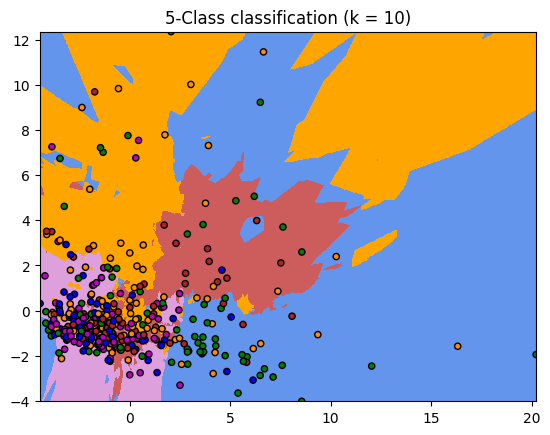

In [72]:
from matplotlib.colors import ListedColormap
h = .02

x_coords_train, y_coords_train = zip(*x_train)
x_max, x_min = max(x_coords_train), min(x_coords_train)
y_max, y_min = max(y_coords_train), min(y_coords_train)

xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])

Z = ss.rankdata(Z).reshape(xx.shape)

cmap_light = ListedColormap(["indianred", "orange", "yellowgreen", "cornflowerblue", "plum"])
cmap_bold = ListedColormap(["firebrick", "darkorange", "green", "blue", "m"])

plt.pcolormesh(xx, yy, Z, cmap=cmap_light, shading="nearest")

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.scatter(
    x=x_coords_train,
    y=y_coords_train,
    c=ss.rankdata(y_train),
    cmap=cmap_bold,
    edgecolors="k",
    s=20,
)
print(set(y_train))
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title(f"5-Class classification (k = {n_neighbors})")

plt.show()

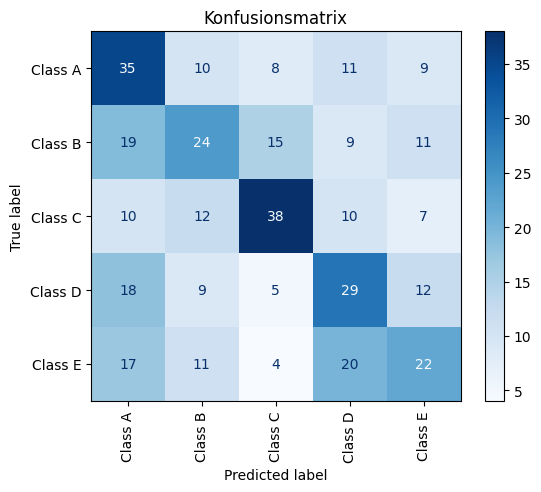

In [71]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
train_cm = confusion_matrix(y_train, knn.predict(x_train))
test_cm = confusion_matrix(y_test, knn.predict(x_test))

class_labels = ["Class A", "Class B", "Class C", "Class D", "Class E"]
disp = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=90)
plt.title("Konfusionsmatrix")
plt.show()

In [11]:
from sklearn.pipeline import Pipeline
from sklearn import set_config
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.base import TransformerMixin, BaseEstimator

class Debug(BaseEstimator, TransformerMixin):
    df = pd.DataFrame()
    def transform(self, X):
        print(pd.DataFrame(X).head())
        print(X.shape)
        return X

    def fit(self, X, y=None, **fit_params):
        return self

# Create Pipeline
knn = KNeighborsClassifier(n_neighbors=n_neighbors)
sfs = SequentialFeatureSelector(estimator=knn,n_features_to_select=n_features_to_select)
possible_steps=[
    ("scaler",              StandardScaler(),   True),
    ("dbg",                 Debug(),            True),
    ("sequential_selector", sfs,                feature_selection),
    ("dbg2",                Debug(),            True),
    ("pca",                 PCA(n_components=2),feature_reduction),
    ("dbg3",                Debug(),            True),
    ("knn",                 knn,                True),
]
steps = [ (name, function) for (name, function, enabled) in possible_steps if enabled]
pipeline = Pipeline(steps=steps)
# Fit pipeline
pipeline.fit(x_train, y_train)


set_config(display="diagram")
pipeline

          0         1
0 -0.223620 -0.339027
1 -0.151133 -0.257415
2  4.158145  1.427992
3  0.335260  0.817753
4 -0.553256 -0.038630
(375, 2)


ValueError: n_features_to_select must be < n_features.

In [ ]:
# Test pipeline on test data
pipeline.score(x_test, y_test)

          0         1
0 -0.920578  1.654649
1  0.663288 -0.063536
2 -1.022596  0.229119
3 -0.622837 -0.031597
4 -0.672825 -0.207155
(125, 2)
          0         1
0 -0.920578  1.654649
1  0.663288 -0.063536
2 -1.022596  0.229119
3 -0.622837 -0.031597
4 -0.672825 -0.207155
(125, 2)
          0         1
0  1.820961  0.519066
1 -0.513942  0.424088
2  0.885096 -0.561073
3  0.418070 -0.462755
4  0.329278 -0.622240
(125, 2)


0.24